In [116]:
### original code by Greg Henselman-Petrusek
### modified by Kushin Mukherjee

In [38]:
from fancyimpute import SoftImpute, BiScaler, IterativeSVD
import numpy as np
import csv
import pandas as pd
import copy
import matplotlib.pyplot as plt
import os

from sklearn.metrics.pairwise import pairwise_distances

from scipy.io import loadmat

In [42]:
proj_dir = os.path.abspath('../../')
data_dir = os.path.join(proj_dir, 'data')


In [61]:
### read in the file ANIMALSexemplarfeaturesbig.txt as a data frame

animal_fn = os.path.join(data_dir, 'LeuvenNorms/ANIMALSexemplarfeaturesbig.txt')
animal_df = pd.read_csv(animal_fn, sep='\t', header=0, index_col=0).reset_index().drop('FFrq',axis=1)

tool_fn = os.path.join(data_dir, 'LeuvenNorms/ARTIFACTSexemplarfeaturesbig.txt')
### read in the file ARTIFACTSexemplarfeaturesbig.txt as a data frame and prevent the utf-8 encoding error
tool_df = pd.read_csv(tool_fn, sep='\t', header=0, index_col=0, encoding='latin-1').reset_index().drop('FFrq',axis=1)







In [68]:
tool_df.shape[1]+animal_df.shape[1]


297

In [90]:
animals = animal_df.columns[1:]
tools = tool_df.columns[1:]

animal_array = np.array(animal_df)[:,1:].T
tool_array = np.array(tool_df)[:,1:].T

In [119]:
full_feat_array = np.vstack([np.hstack([animal_array,np.zeros((animal_array.shape[0],tool_array.shape[1]))])\
                    ,np.hstack([np.zeros((tool_array.shape[0],animal_array.shape[1])),tool_array])]).astype(np.float)

full_feat_array[full_feat_array>0] =1 
full_concept_list = np.hstack([animals,tools])
(d1, d2) = full_feat_array.shape



distmat = pairwise_distances(full_feat_array, metric='cosine')

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_16040/3516397392.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ,np.hstack([np.zeros((tool_array.shape[0],animal_array.shape[1])),tool_array])]).astype(np.float)


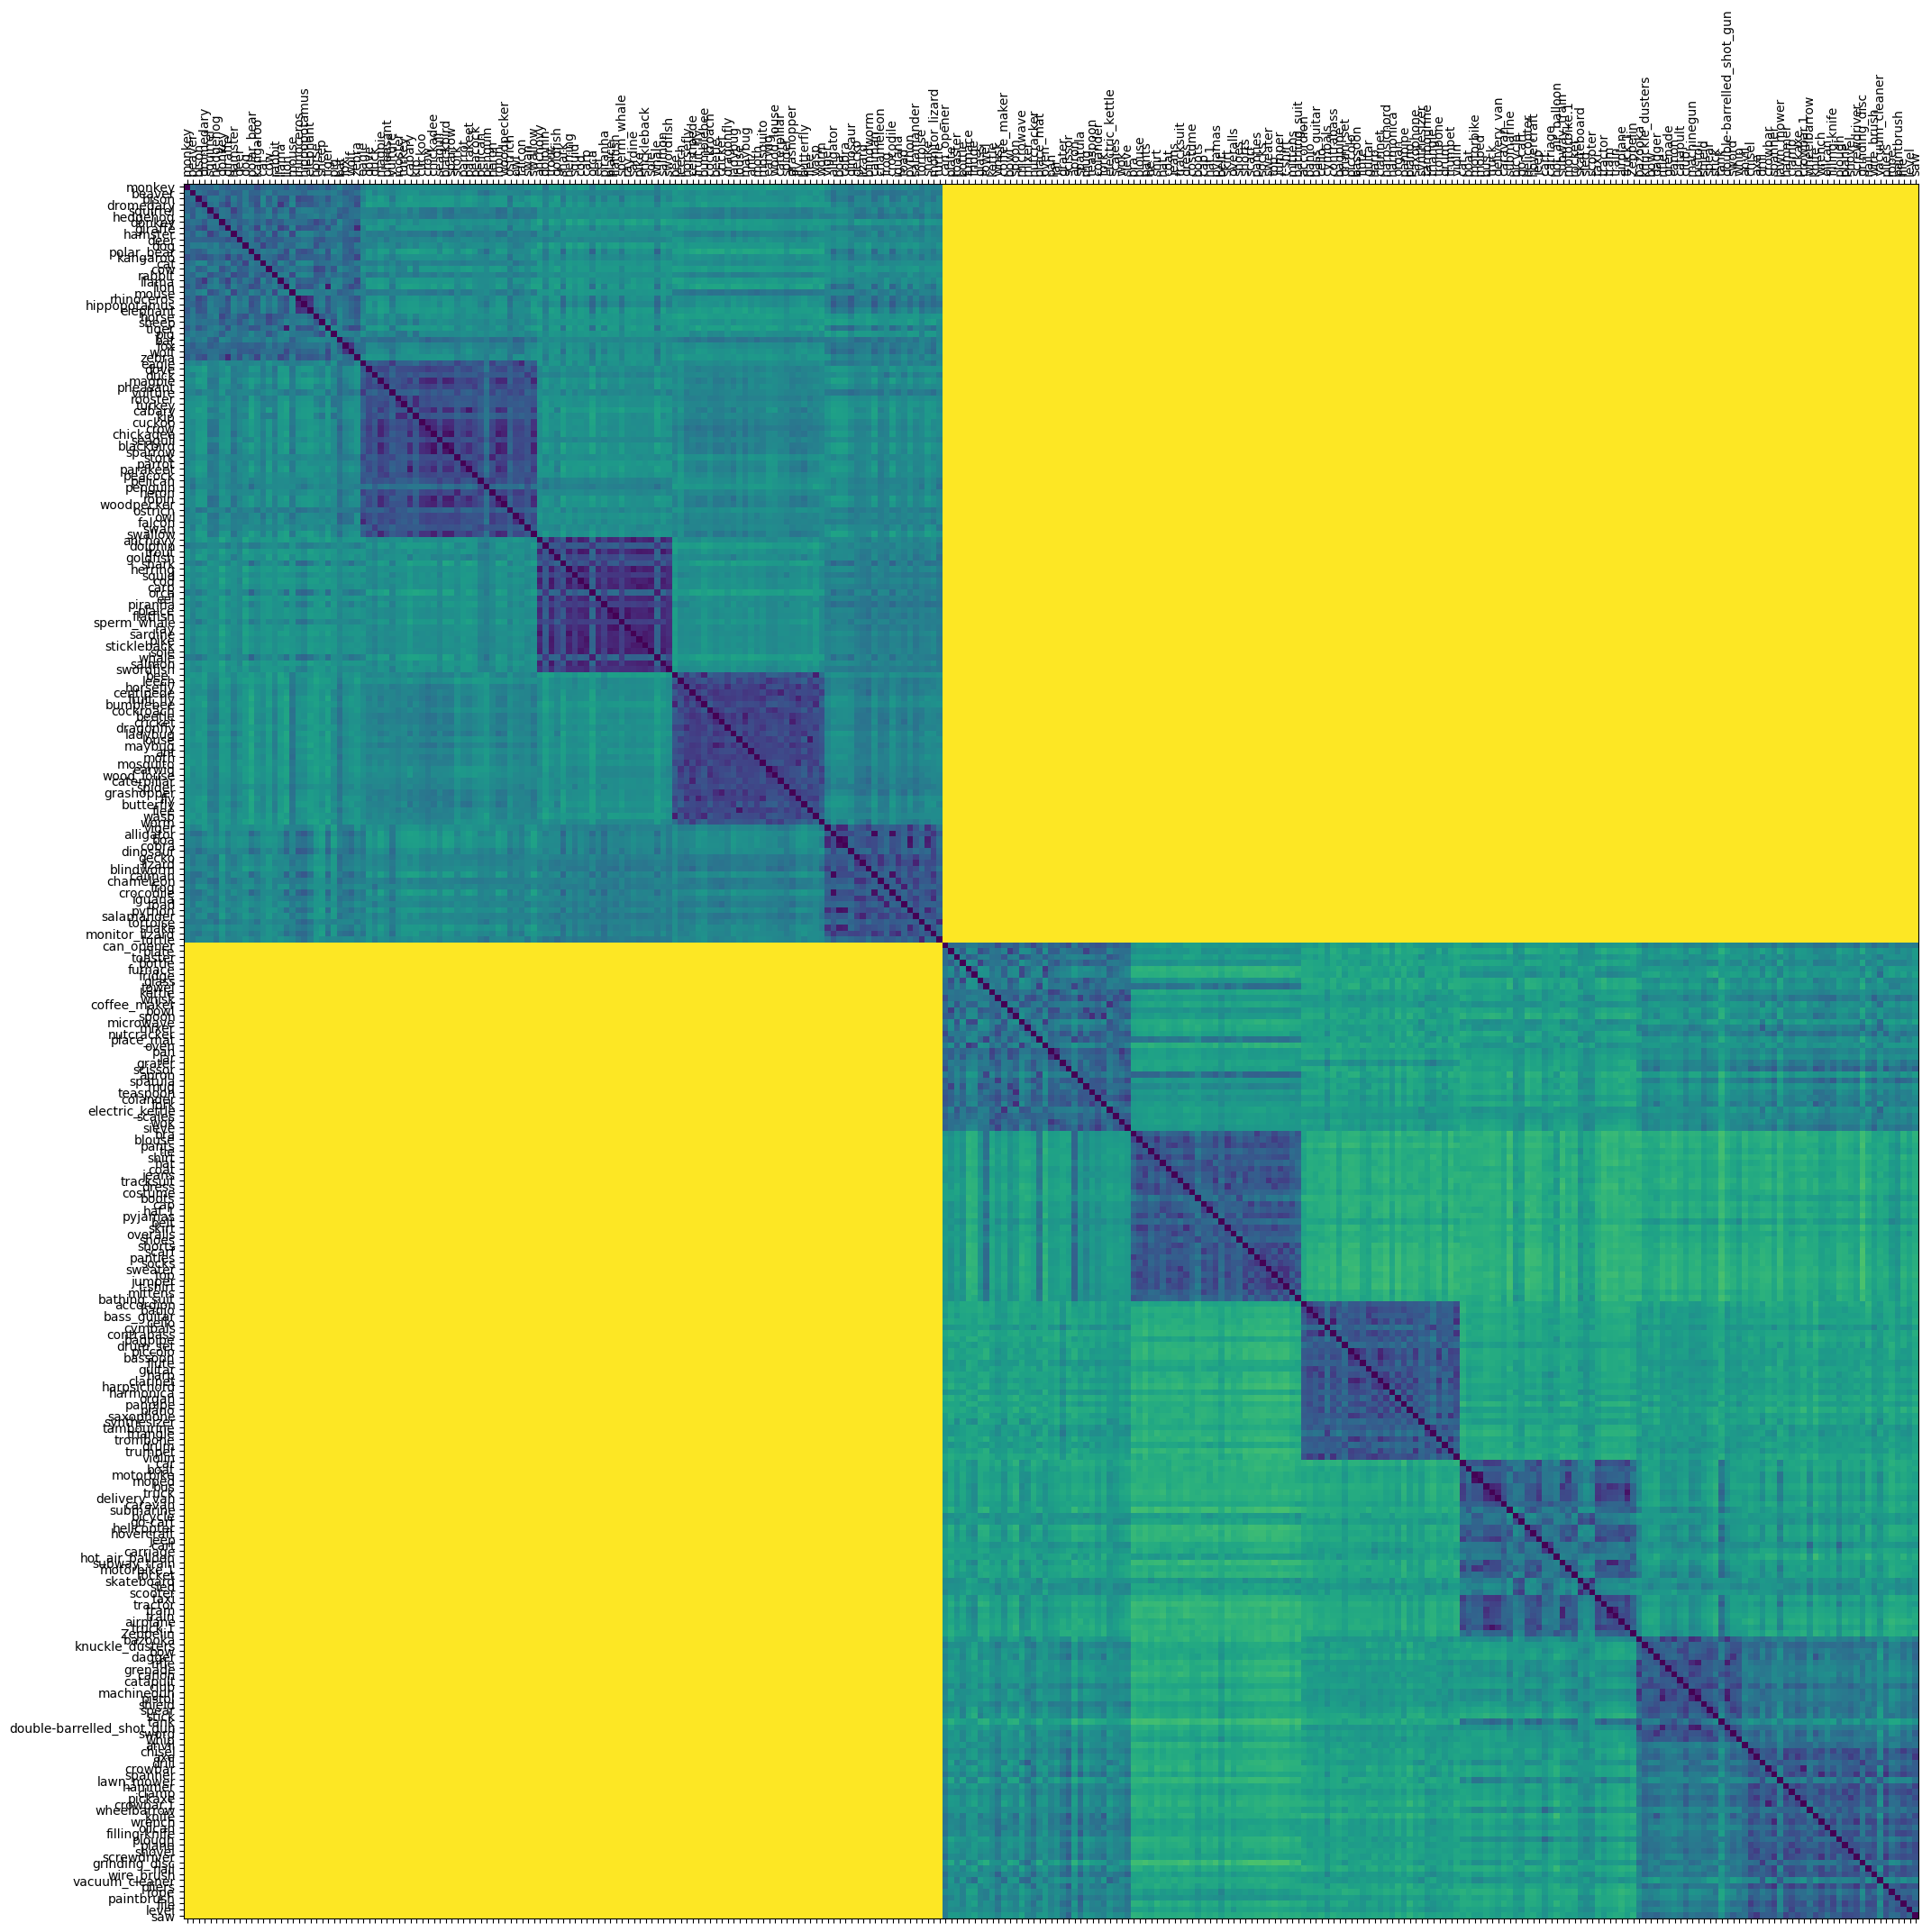

In [118]:
fig, axes = plt.subplots(1, 1, figsize=(25, 25))
axes.matshow(distmat)
### add the strings in full_concept_list as the x and y ticks
axes.set_xticks(range(len(full_concept_list)), full_concept_list, rotation=90)
axes.set_yticks(range(len(full_concept_list)), full_concept_list)
plt.show()

In [120]:
dropped_array = copy.deepcopy(full_feat_array)
dropped_positive_count = 0
dropped_negative_count = 0


#    Choose dropout parameters
#   -------------------------

p_droptruepos   =   0.5 # probability of dropping a true positive value
p_droptrueneg   =   0.5 # probability of dropping a true negative (zero) value

#   Replace some entries with NaN's
#   -------------------------------

for row in range(d1):
    for col in range(d2):
        if dropped_array[row][col] == 1:
            if np.random.uniform(0,1) < p_droptruepos:
                dropped_array[row][col] = np.NaN
                dropped_positive_count +=1
        else:
            if np.random.uniform(0, 1) < p_droptrueneg:
                dropped_array[row][col] = np.NaN
                dropped_negative_count +=1       

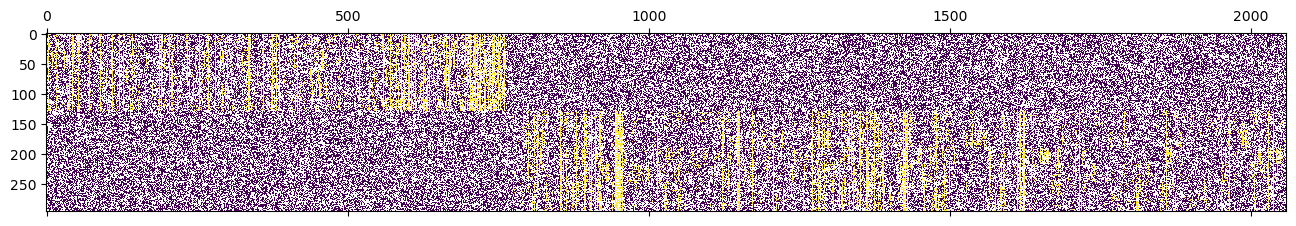

In [127]:
plt.matshow(dropped_array)

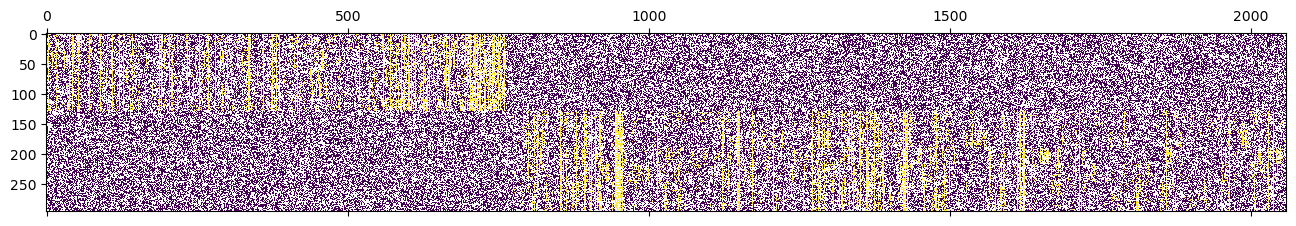

In [122]:
plt.matshow(dropped_array)

In [124]:
for iter in range(1):
    filled_array = IterativeSVD(min_value=0, max_value=1,rank=20).fit_transform(dropped_array)
    # X_guessed = np.round(X_filled)
    # np.clip(X_guessed, 0, 1)

    # for row in range(d1):
    #     for col in range(d2):
    #         if X_guessed[row][col] == 1:
    #             dropped_array_partfilled[row][col] = 1

[IterativeSVD] Iter 1: observed MAE=0.093673
[IterativeSVD] Iter 2: observed MAE=0.091262
[IterativeSVD] Iter 3: observed MAE=0.082395
[IterativeSVD] Iter 4: observed MAE=0.068928
[IterativeSVD] Iter 5: observed MAE=0.055307
[IterativeSVD] Iter 6: observed MAE=0.049047
[IterativeSVD] Iter 7: observed MAE=0.047192
[IterativeSVD] Iter 8: observed MAE=0.046569
[IterativeSVD] Iter 9: observed MAE=0.046311
[IterativeSVD] Iter 10: observed MAE=0.046181
[IterativeSVD] Iter 11: observed MAE=0.046103
[IterativeSVD] Iter 12: observed MAE=0.046050
[IterativeSVD] Iter 13: observed MAE=0.046010
[IterativeSVD] Iter 14: observed MAE=0.045978
[IterativeSVD] Iter 15: observed MAE=0.045952
[IterativeSVD] Iter 16: observed MAE=0.045930
[IterativeSVD] Iter 17: observed MAE=0.045911
[IterativeSVD] Iter 18: observed MAE=0.045894


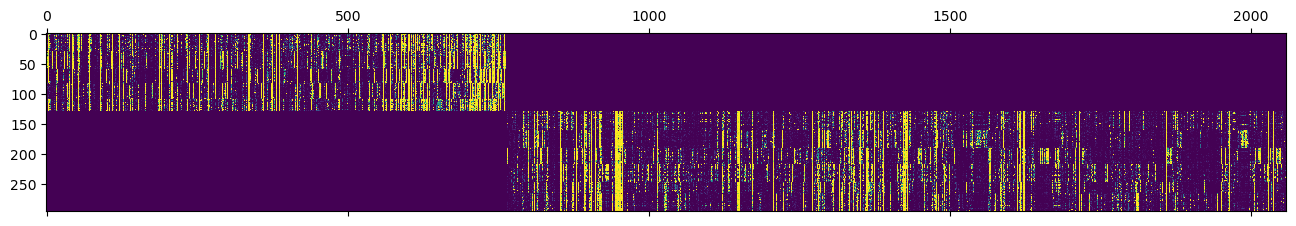

In [126]:
plt.matshow(filled_array)

In [64]:
filename="leuven_data_set_numbers_only.mat"

In [65]:
leuven_array = loadmat(filename)
leuven_array = leuven_array['leuven_array']
leuven_array = leuven_array.astype(np.float)


/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_16040/2276205295.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  leuven_array = leuven_array.astype(np.float)


In [13]:
(d1, d2) = leuven_array.shape

dropped_array = copy.deepcopy(leuven_array)
dropped_positive_count = 0
dropped_negative_count = 0


[IterativeSVD] Iter 1: observed MAE=0.074760
[IterativeSVD] Iter 2: observed MAE=0.078980
[IterativeSVD] Iter 3: observed MAE=0.076942
[IterativeSVD] Iter 4: observed MAE=0.065934
[IterativeSVD] Iter 5: observed MAE=0.052016
[IterativeSVD] Iter 6: observed MAE=0.043531
[IterativeSVD] Iter 7: observed MAE=0.039410
[IterativeSVD] Iter 8: observed MAE=0.037257
[IterativeSVD] Iter 9: observed MAE=0.036053
[IterativeSVD] Iter 10: observed MAE=0.035332
[IterativeSVD] Iter 11: observed MAE=0.034876
[IterativeSVD] Iter 12: observed MAE=0.034571
[IterativeSVD] Iter 13: observed MAE=0.034358
[IterativeSVD] Iter 14: observed MAE=0.034204
[IterativeSVD] Iter 15: observed MAE=0.034089
[IterativeSVD] Iter 16: observed MAE=0.033999
[IterativeSVD] Iter 17: observed MAE=0.033927
[IterativeSVD] Iter 18: observed MAE=0.033868
[IterativeSVD] Iter 19: observed MAE=0.033817
[IterativeSVD] Iter 20: observed MAE=0.033773
[IterativeSVD] Iter 21: observed MAE=0.033734
[IterativeSVD] Iter 22: observed MAE=0.0336

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_16040/1402170942.py:91: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


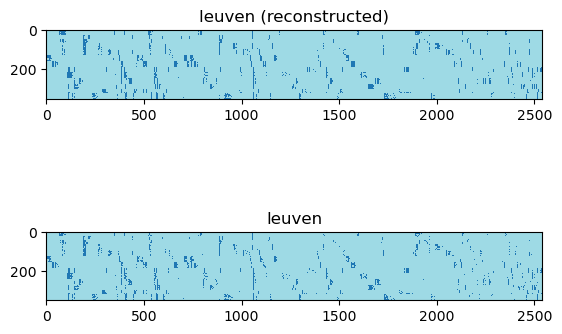

In [25]:
#    Choose dropout parameters
#   -------------------------

p_droptruepos   =   0.5 # probability of dropping a true positive value
p_droptrueneg   =   0.5 # probability of dropping a true negative (zero) value

#   Replace some entries with NaN's
#   -------------------------------

for row in range(d1):
    for col in range(d2):
        if dropped_array[row][col] == 1:
            if np.random.uniform(0,1) < p_droptruepos:
                dropped_array[row][col] = np.NaN
                dropped_positive_count +=1
        else:
            if np.random.uniform(0, 1) < p_droptrueneg:
                dropped_array[row][col] = np.NaN
                dropped_negative_count +=1                

#   Matrix completion with IterativeSVD
#   -----------------------------------
#       -   we apply matrix completion to the partially masked matrix; the result has real-valued entries, which we round to 0/1
#       -   you can play with the rank parameter to get different results
#       -   as Tim predicted, higher ranks seem to support recovery of rows that have a higher degree of variation
#       -   the fancyimpute library has a range of other algorithms, in addition to IterativeSVD

dropped_array_partfilled = copy.deepcopy(dropped_array)
for iter in range(1):
    X_filled = IterativeSVD(min_value=0, max_value=1,rank=20).fit_transform(dropped_array_partfilled)
    X_guessed = np.round(X_filled)
    np.clip(X_guessed, 0, 1)

    for row in range(d1):
        for col in range(d2):
            if X_guessed[row][col] == 1:
                dropped_array_partfilled[row][col] = 1

#   Evaluate performance of the reconstruction procedure
#   ----------------------------------------------------

err_count = np.sum( np.round(X_guessed) != leuven_array )
pct_error = err_count / np.prod(leuven_array.shape)
pct_nonzero_true = np.count_nonzero(leuven_array) / np.product(leuven_array.shape)
pct_pos_correctly_identified = np.count_nonzero( (X_guessed == 1) & (leuven_array ==1) )/np.count_nonzero(leuven_array ==1)
pct_pos_previously_identified = np.count_nonzero(dropped_array == 1)/np.count_nonzero(leuven_array)
err_weighted = np.sum( np.abs( np.round(X_guessed) - leuven_array) )

err_count_above = np.sum( np.abs( np.round(X_guessed) > leuven_array) )
err_count_below = np.sum( np.abs( np.round(X_guessed) < leuven_array) )
# 10258.0
# 10395.0
# 10398

print("Let K    = number of entries in the matrix")
print("Let Kt   = number of positive entries in the matrix (ground truth)")
print("Let Kf   = number of negative entries in the matrix (ground truth)")
print("------------------------------------------------------------------")
print(f"masked positives                            {dropped_positive_count}        ")
print(f"masked negatives                            {dropped_negative_count}        ")
print(f"entries guessed incorrect (num)             {err_count}                     ")
print(f"entries guessed incorrect (num/K)           {pct_error}                     ")
print(f"Kt/K                                        {pct_nonzero_true}              ")
print(f"(# correct pos guess)/Kt                    {pct_pos_correctly_identified}  ")
print(f"(# correct pos not masked)/Kt               {pct_pos_previously_identified} ")
print(f"false positives                             {err_count_above}               ")
print(f"false negatives                             {err_count_below}               ")

# EXAMPLE OUTPUT:
# Let K    = number of entries in the matrix
# Let Kt   = number of positive entries in the matrix (ground truth)
# Let Kf   = number of negative entries in the matrix (ground truth)
# ------------------------------------------------------------------
# masked positives                            3660        
# masked negatives                            384155        
# entries guessed incorrect (num)             5430                     
# entries guessed incorrect (num/K)           0.006088187906369724                     
# Kt/K                                        0.042337012033981734              
# (# correct pos guess)/Kt                    0.9819650423728814  
# (# correct pos not masked)/Kt               0.903072033898305 
# false positives                             4749               
# false negatives                             681  


fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1 )
ax0.imshow( X_guessed, cmap='tab20_r', interpolation='nearest')
ax1.imshow( leuven_array, cmap='tab20_r', interpolation='nearest')
ax0.title.set_text('leuven (reconstructed)')
ax1.title.set_text('leuven')

fig.show()


In [26]:
## get the frobeniums norm of leuven_array and X_guessed

frobenius_norm = np.linalg.norm(leuven_array - X_guessed)
print(frobenius_norm)

112.97344820797495


In [27]:
cors =[]
for i in range(leuven_array.shape[0]):
    cors.append(np.corrcoef(leuven_array[i,:], X_guessed[i,:])[0,1])

In [28]:
np.mean(cors)

0.8316298838423772

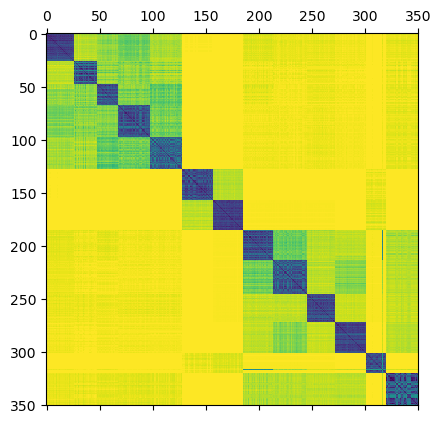

In [34]:
plt.matshow(pairwise_distance)

In [37]:
## get all the diagonal values from pairwise_distance

diag = np.diag(pairwise_distance)
diag


array([0.16369345, 0.16242398, 0.11234112, 0.11678711, 0.16258144,
       0.12040679, 0.15309287, 0.09360777, 0.17402324, 0.12307773,
       0.1843515 , 0.14844038, 0.14561121, 0.11339137, 0.13932565,
       0.1188811 , 0.15471484, 0.13306794, 0.17199132, 0.11357356,
       0.16498995, 0.15263642, 0.19032279, 0.19417704, 0.18940063,
       0.22699965, 0.11300994, 0.27272727, 0.13708901, 0.22765671,
       0.186965  , 0.10439628, 0.28571429, 0.08547081, 0.14239098,
       0.29806598, 0.17427718, 0.15311879, 0.08313434, 0.18590842,
       0.25515054, 0.12723191, 0.15229269, 0.17065877, 0.12226618,
       0.27269017, 0.18555363, 0.17934321, 0.1739198 , 0.1098774 ,
       0.19990531, 0.21750597, 0.21800325, 0.15828083, 0.19978347,
       0.23833536, 0.10951061, 0.15487715, 0.29097032, 0.13738687,
       0.16707728, 0.25354887, 0.19918293, 0.24091677, 0.22274167,
       0.21500838, 0.20645172, 0.24468521, 0.1693352 , 0.13345926,
       0.19797043, 0.16726688, 0.18517722, 0.17371777, 0.16653